# Spline-Based Selectivity

Penalized B-spline selectivity with smoothness control

## Overview

Spline-based selectivity provides a flexible, semi-parametric alternative to logistic functional forms. Rather than imposing a specific shape (monotone or dome-shaped), a B-spline basis is used to represent selectivity as a smooth function of age, with the degree of smoothness controlled by a penalty on the second differences of the spline coefficients.

## Model definition

Let $\mathbf{B}(a)$ be a B-spline basis matrix evaluated at ages $a$, with $K$ basis functions and coefficient vector $\boldsymbol{\beta}$. The log-selectivity is

$$
\log\,\text{sel}(a) = \mathbf{B}(a)\,\boldsymbol{\beta}
$$

with selectivity normalized so the maximum equals 1:

$$
\text{sel}(a) = \frac{\exp(\mathbf{B}(a)\,\boldsymbol{\beta})}
{\max_a \exp(\mathbf{B}(a)\,\boldsymbol{\beta})}.
$$

Smoothness is enforced via a penalty on second differences:

$$
\text{penalty} = \frac{\lambda}{2} \sum_{k=3}^{K} (\beta_k - 2\beta_{k-1} + \beta_{k-2})^2
$$

where $\lambda$ controls the trade-off between fit and smoothness.

In [ ]:
library(ggplot2)
library(dplyr)



Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

## Basis visualization

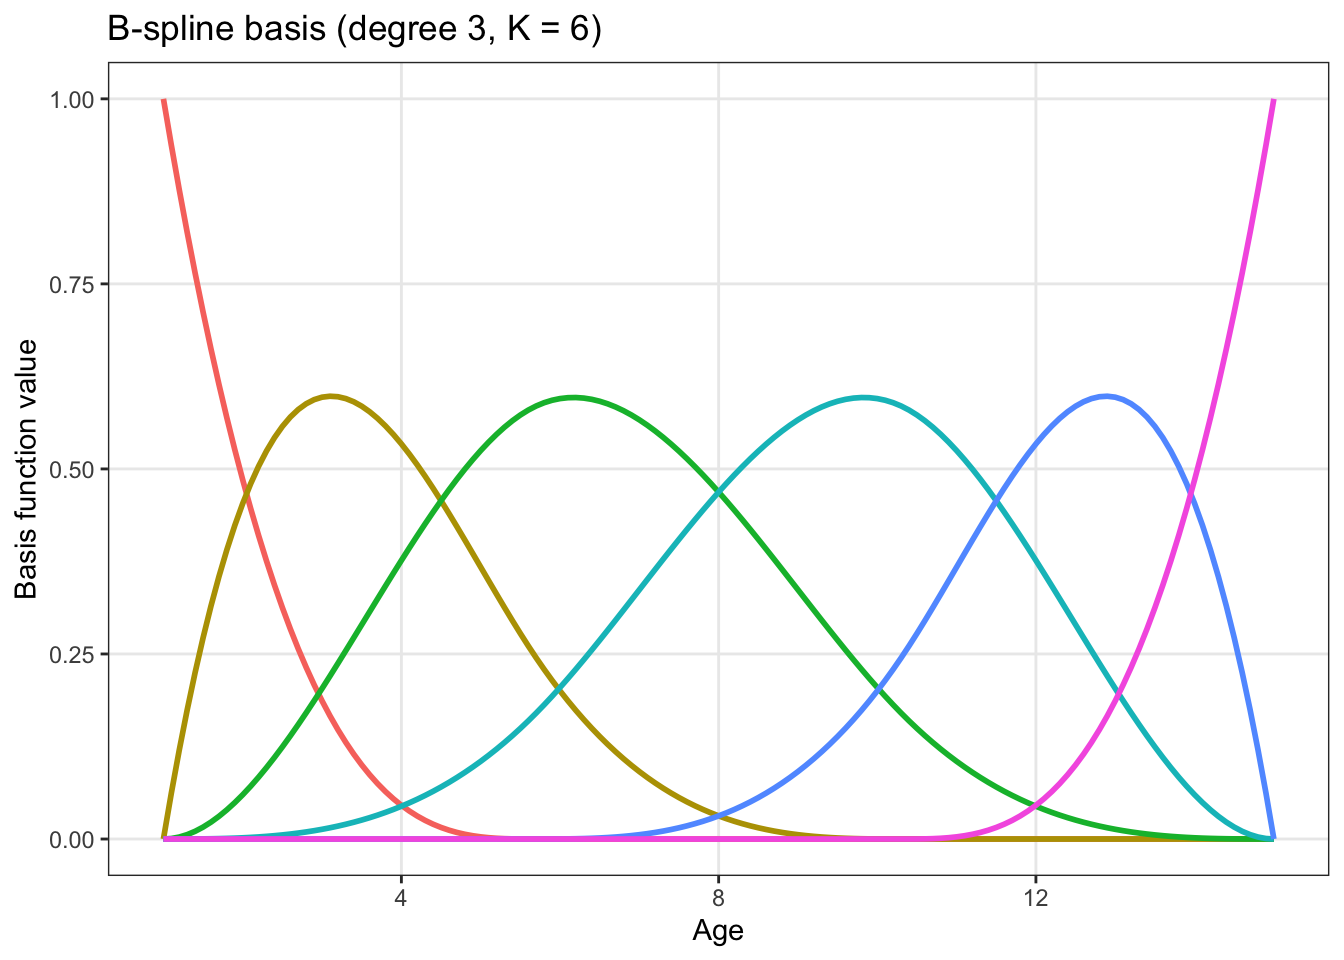

In [ ]:
K <- 6
B <- bs(ages, df = K, degree = 3, intercept = TRUE)
basis_df <- as.data.frame(B) %>%
  mutate(age = ages) %>%
  tidyr::pivot_longer(-age, names_to = "basis", values_to = "value")

ggplot(basis_df, aes(x = age, y = value, color = basis)) +
  geom_line(linewidth = 1) +
  labs(x = "Age", y = "Basis function value",
       title = "B-spline basis (degree 3, K = 6)") +
  theme_bw(base_size = 11) +
  theme(legend.position = "none", panel.grid.minor = element_blank())


## Example curves

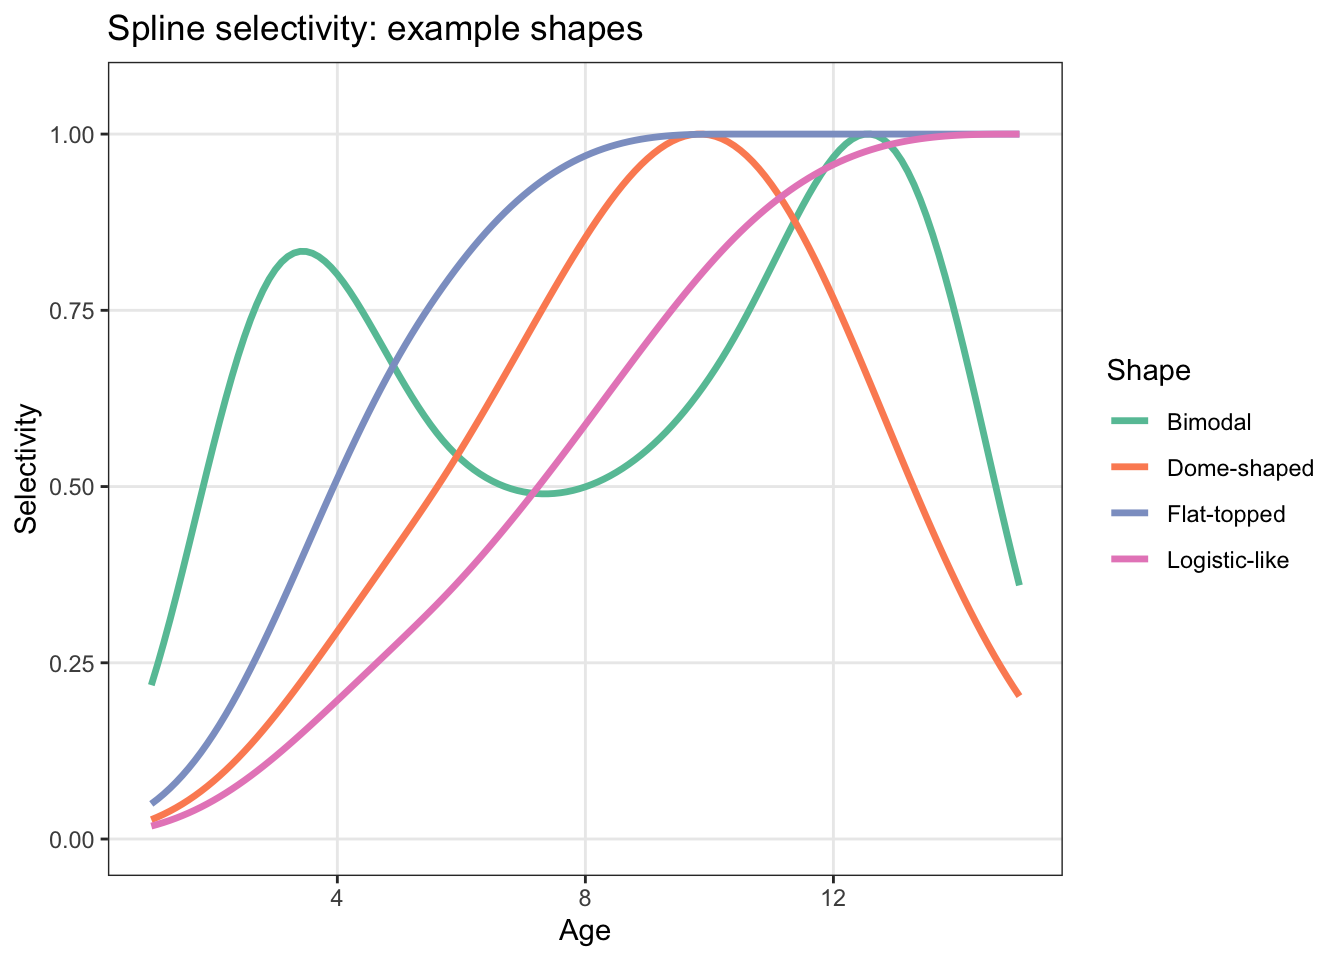

In [ ]:
spline_sel <- function(age, beta, B) {
  log_sel <- B %*% beta
  sel <- exp(log_sel - max(log_sel))
  as.numeric(sel)
}

B_mat <- bs(ages, df = K, degree = 3, intercept = TRUE)

examples <- tibble(
  name = c("Logistic-like", "Dome-shaped", "Bimodal", "Flat-topped"),
  beta = list(
    c(-3, -1, 0, 1, 1, 1),
    c(-3, -1, 0, 1, 0, -1),
    c(-1, 1, -0.5, 0, 1, -0.5),
    c(-3, -1, 0, 0, 0, 0)
  )
)

curve_data <- examples %>%
  rowwise() %>%
  do({
    ex <- .
    tibble(
      name = ex$name,
      age = ages,
      selectivity = spline_sel(ages, ex$beta, B_mat)
    )
  }) %>%
  ungroup()

ggplot(curve_data, aes(x = age, y = selectivity, color = name)) +
  geom_line(linewidth = 1.2) +
  scale_y_continuous(limits = c(0, 1.05)) +
  scale_color_brewer(palette = "Set2", name = "Shape") +
  labs(x = "Age", y = "Selectivity",
       title = "Spline selectivity: example shapes") +
  theme_bw(base_size = 11) +
  theme(panel.grid.minor = element_blank())


## RTMB implementation

*Placeholder: RTMB objective with spline coefficients as parameters, smoothness penalty as a tuning parameter or estimated, and MCMC sampling.*

In [ ]:
library(RTMB)

# Objective function skeleton
f <- function(parms) {
  getAll(data, parms, warn = FALSE)
  log_sel <- B %*% beta
  sel_hat <- exp(log_sel - max(log_sel))

  # Second-difference penalty
  K <- length(beta)
  d2 <- beta[3:K] - 2 * beta[2:(K-1)] + beta[1:(K-2)]
  penalty <- 0.5 * exp(log_lambda) * sum(d2^2)

  nll <- penalty
  # Add data likelihood here
  # nll <- nll - sum(dnorm(sel_obs, sel_hat, sel_sd, log = TRUE))

  ADREPORT(sel_hat)
  nll
}
